# Notebook to explore the MIT-BIH Arrhythmia Data

## Setup

In [13]:
%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.append("../")

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from collections import Counter
from scripts.load_data import download_mitbih, load_record
from scripts.plotting import plot_label_distribution, plot_frequency_spectrum, plot_ecg_segment, plot_pca_embedding, plot_rr_intervals
from scripts.preprocess import segment_beats, bandpass_filter, notch_filter, normalize, compute_rr_intervals, build_rr_lookup
from scripts.extract import extract_beat_level_info
from scripts.utils import get_project_path

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
# Download and load record 100
download_mitbih(records = ["100"])
data = load_record("100")

signal = data["signal"]
annotations = data["annotations"]
fs = data["fs"]  #sampling frequency

print(f"Signal shape: {signal.shape}")
print(f"Sampling frequency: {fs} Hz")
print(f"Number of annotations: {len(annotations['symbols'])}")

100.hea already exists at C:\Users\vscerra\Desktop\DataScienceProjects\mitbih_arrhythmia_project\data/raw/mitdb\100.hea
100.dat already exists at C:\Users\vscerra\Desktop\DataScienceProjects\mitbih_arrhythmia_project\data/raw/mitdb\100.dat
100.atr already exists at C:\Users\vscerra\Desktop\DataScienceProjects\mitbih_arrhythmia_project\data/raw/mitdb\100.atr
Signal shape: (650000, 2)
Sampling frequency: 360 Hz
Number of annotations: 2274


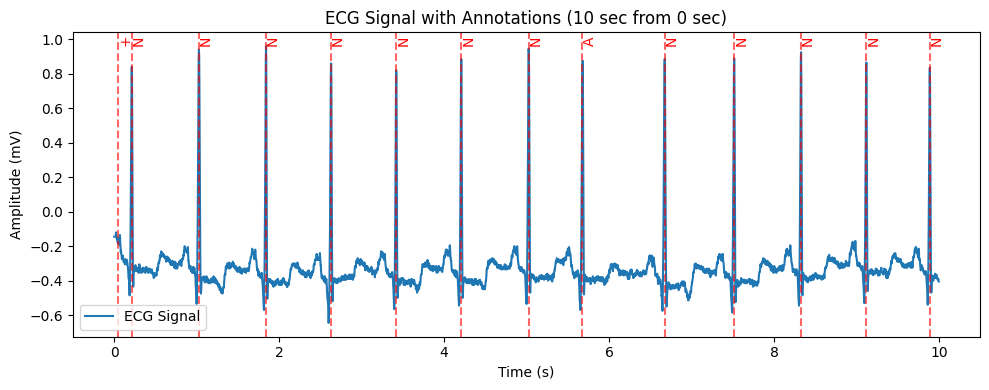

In [15]:
# Plot a segment of the ECG signal with annotations
plot_ecg_segment(signal, annotations, fs, start_sec = 0, duration_sec = 10)

In [16]:
# Annotation symbol summary
symbol_counts = Counter(annotations["symbols"])
print("Annotation Symbol Frequencies:")
for sym, count in symbol_counts.items():
    print(f"{sym}: {count}")

Annotation Symbol Frequencies:
+: 1
N: 2239
A: 33
V: 1


## Preprocess the Data and Check the Frequency Spectrum

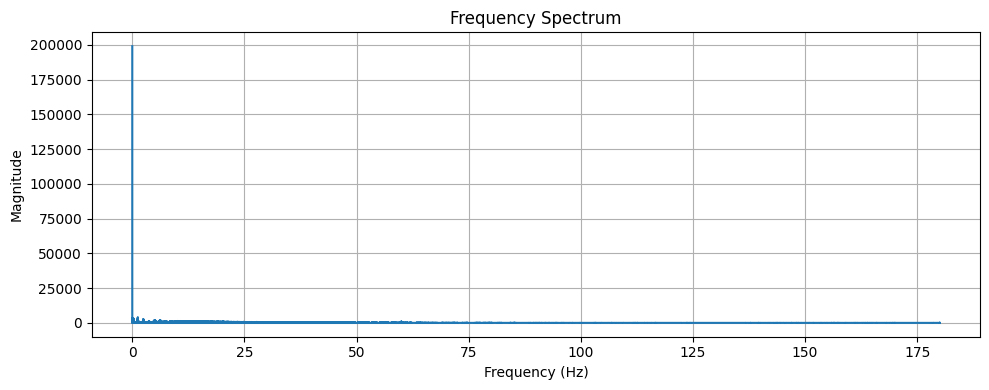

In [17]:
# check the frequcncy content before filtering
plot_frequency_spectrum(signal, fs, max_freq = 1000, channel = 0)

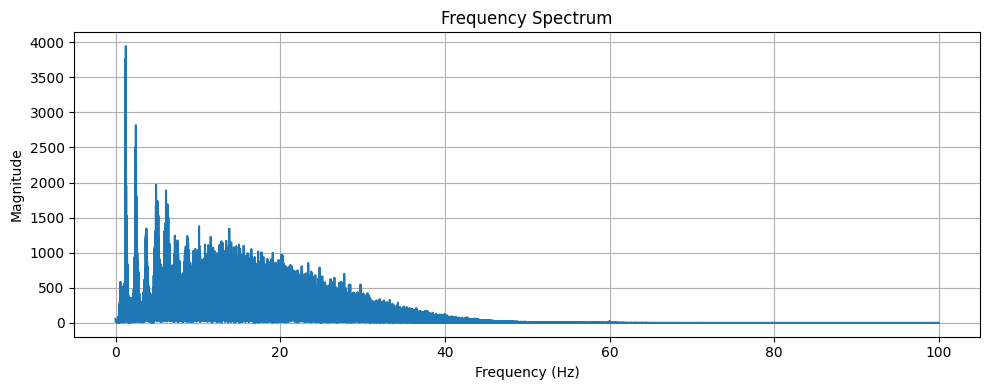

In [18]:
# Apply bandpass
filtered = bandpass_filter(signal, fs, 0.5, 40)

# Apply notch filter if 60 Hz interference is observed in spectrum
#filtered = notch_filter(filtered, fs, freq = 60.0)

# Normalize for modeling
normalized = normalize(filtered, method = "zscore")

# Plot post-filtered spectrum if you want to verify results
plot_frequency_spectrum(normalized, fs, max_freq = 100, channel = 0)

## Beat Segmentation

This step extracts fixed-length windows around each annotated R-peak

In [19]:
segments, labels, indices = segment_beats(normalized, annotations, fs, window_size_sec = 0.6)

print(f"Segment Shape: {segments.shape}") # (n_beats, window_samples, n_channels)
print(f"First 5 Labels: {labels[:5]}")

Segment Shape: (2272, 216, 2)
First 5 Labels: ['N', 'N', 'N', 'N', 'N']


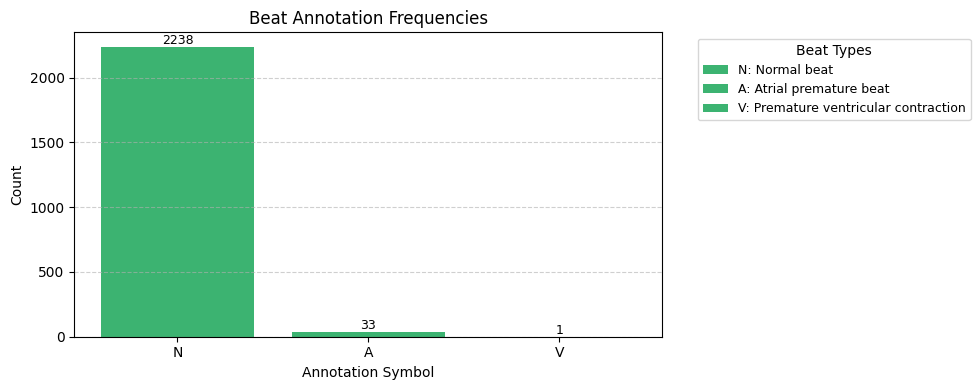

In [20]:
label_counts = Counter(labels)

plot_label_distribution(label_counts, title = "Beat Annotation Frequencies")

## Principal Component Analysis (PCA)

PCA provides a fast, linear, and interpretable way to visualize beat structure and overlap. 

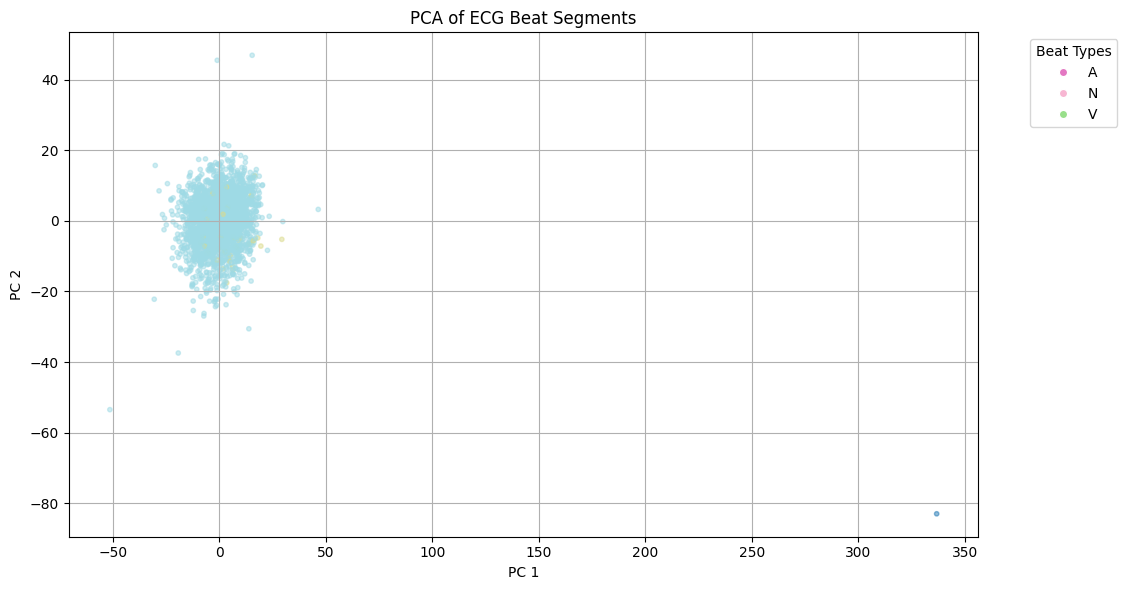

In [21]:
plot_pca_embedding(segments, labels)

## Explore Temporal Context - Interbeat Intervals

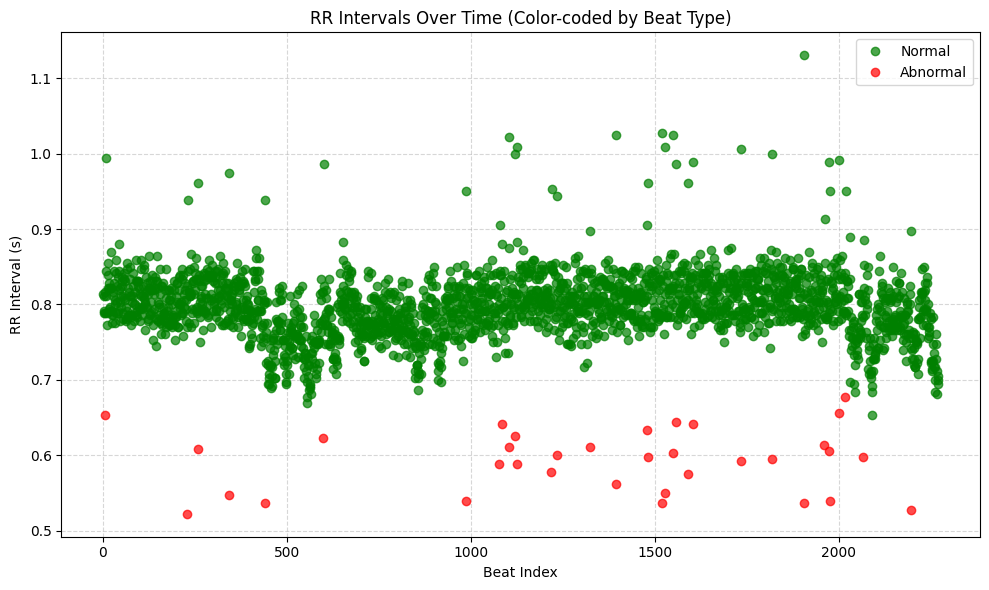

In [22]:
rr_lookup = build_rr_lookup(annotations, fs)

# use the indices returned by segment_beats to fetch rr_intervals
rr_intervals = [rr_lookup.get(idx, np.nan) for idx in indices]
plot_rr_intervals(np.array(rr_intervals), labels)

## Process and Save a Larger Dataset

In [23]:
# Download once — only needed the first time
download_mitbih(records=["100", "101", "102", "103", "104"])

100.hea already exists at C:\Users\vscerra\Desktop\DataScienceProjects\mitbih_arrhythmia_project\data/raw/mitdb\100.hea
100.dat already exists at C:\Users\vscerra\Desktop\DataScienceProjects\mitbih_arrhythmia_project\data/raw/mitdb\100.dat
100.atr already exists at C:\Users\vscerra\Desktop\DataScienceProjects\mitbih_arrhythmia_project\data/raw/mitdb\100.atr
101.hea already exists at C:\Users\vscerra\Desktop\DataScienceProjects\mitbih_arrhythmia_project\data/raw/mitdb\101.hea
101.dat already exists at C:\Users\vscerra\Desktop\DataScienceProjects\mitbih_arrhythmia_project\data/raw/mitdb\101.dat
101.atr already exists at C:\Users\vscerra\Desktop\DataScienceProjects\mitbih_arrhythmia_project\data/raw/mitdb\101.atr
102.hea already exists at C:\Users\vscerra\Desktop\DataScienceProjects\mitbih_arrhythmia_project\data/raw/mitdb\102.hea
102.dat already exists at C:\Users\vscerra\Desktop\DataScienceProjects\mitbih_arrhythmia_project\data/raw/mitdb\102.dat
102.atr already exists at C:\Users\vscer

In [24]:
record_ids = ["100", "101", "102", "103", "104"]
all_beats = []
all_segments = []

for rid in record_ids:
    print(f"Processing record {rid}...")
    info = extract_beat_level_info(rid)

    for i, (rr, label) in enumerate(zip(info["rr_intervals"], info["labels"])):
        if not np.isnan(rr):
            all_beats.append({
                "record": rid,
                "label": label,
                "rr_interval": rr,
                "sample_index": info["sample_indices"][i],
            })
            all_segments.append(info["segments"][i])

# Save dataframe and segments
df_beats = pd.DataFrame(all_beats)
save_path = get_project_path("data", "processed")

df_beats.to_csv(os.path.join(save_path, "beats_dataset.csv"), index = False)
np.save(os.path.join(save_path, "beat_segments.npy"), np.stack(all_segments))
df_beats.head(10)

Processing record 100...
Processing record 101...
Processing record 102...
Processing record 103...
Processing record 104...


,record,label,rr_interval,sample_index
0,100,N,0.163889,77
1,100,N,0.813889,370
2,100,N,0.811111,662
3,100,N,0.788889,946
4,100,N,0.791667,1231
5,100,N,0.788889,1515
6,100,N,0.816667,1809
7,100,A,0.652778,2044
8,100,N,0.994444,2402
9,100,N,0.844444,2706
